# PPO

In [2]:
import numpy as np
import tensorflow as tf
import gymnasium as gym
import os
import matplotlib.pyplot as plt

# Disable eager execution to use TF1 style
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()


In [3]:
class ValueNetwork:
    def __init__(self, num_features, hidden_size, learning_rate=0.0001):
        self.num_features = num_features
        self.hidden_size = hidden_size
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.sess = tf.compat.v1.Session()
            # Placeholders for state observations and target returns
            self.obs_ph = tf.compat.v1.placeholder(tf.float32, [None, num_features], name='obs')
            self.targets_ph = tf.compat.v1.placeholder(tf.float32, [None], name='targets')
            # Hidden layer using Keras Dense layer
            hidden = tf.compat.v1.keras.layers.Dense(hidden_size, activation=tf.nn.relu, name='hidden')(self.obs_ph)
            # Output layer: predicts a single scalar value per state
            self.value = tf.squeeze(tf.compat.v1.keras.layers.Dense(1, name='value_output')(hidden), axis=1)
            # Loss: Mean Squared Error (manually computed)
            self.loss = tf.reduce_mean(tf.square(self.targets_ph - self.value))
            # Optimizer and training op
            self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(self.loss)
            self.sess.run(tf.compat.v1.global_variables_initializer())
    
    def predict(self, states):
        return self.sess.run(self.value, feed_dict={self.obs_ph: states})
    
    def update(self, states, targets):
        loss_val, _ = self.sess.run([self.loss, self.train_op],
                                    feed_dict={self.obs_ph: states, self.targets_ph: targets})
        return loss_val


In [4]:
class PolicyNetwork:
    def __init__(self, num_features, num_actions, hidden_sizes, epsilon=0.2, learning_rate=0.0005):
        self.num_features = num_features
        self.num_actions = num_actions
        self.epsilon = epsilon  # PPO clipping parameter
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.sess = tf.compat.v1.Session()
            # Placeholders for observations, actions taken, advantages, and old log probabilities
            self.obs_ph = tf.compat.v1.placeholder(tf.float32, [None, num_features], name='obs')
            self.actions_ph = tf.compat.v1.placeholder(tf.float32, [None, num_actions], name='actions')
            self.advantages_ph = tf.compat.v1.placeholder(tf.float32, [None], name='advantages')
            self.old_log_probs_ph = tf.compat.v1.placeholder(tf.float32, [None], name='old_log_probs')
            
            # Build hidden layers using Keras Dense layers
            out = self.obs_ph
            for i, size in enumerate(hidden_sizes):
                out = tf.compat.v1.keras.layers.Dense(size, activation=tf.nn.tanh, name=f'hidden_{i}')(out)
            # Output layer for the mean of the Gaussian distribution
            self.mean = tf.compat.v1.keras.layers.Dense(num_actions, activation=None, name='mean')(out)
            # Log standard deviation (trainable, state-independent)
            self.log_std = tf.compat.v1.get_variable("log_std", shape=[num_actions], initializer=tf.zeros_initializer())
            self.std = tf.exp(self.log_std)
            
            # Define a normal distribution for actions
            dist = tf.compat.v1.distributions.Normal(loc=self.mean, scale=self.std)
            # Sample actions from this distribution
            self.sampled_action = dist.sample()
            # Compute log probability of actions taken (summed over dimensions)
            self.log_prob = tf.reduce_sum(dist.log_prob(self.actions_ph), axis=1)
            
            # PPO loss: calculate the probability ratio and then clip it
            ratio = tf.exp(self.log_prob - self.old_log_probs_ph)
            surrogate1 = ratio * self.advantages_ph
            surrogate2 = tf.clip_by_value(ratio, 1 - self.epsilon, 1 + self.epsilon) * self.advantages_ph
            self.loss = -tf.reduce_mean(tf.minimum(surrogate1, surrogate2))
            
            
            # Optimizer and training operation
            self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(self.loss)
            self.sess.run(tf.compat.v1.global_variables_initializer())
    

    def predict(self, states):
        # Return the mean and log_std given states
        mean, log_std = self.sess.run([self.mean, self.log_std], feed_dict={self.obs_ph: states})
        std = np.exp(log_std)
        return mean, std


    def get_action(self, state):
        # For a single state, sample an action and compute its log probability
        feed_dict = {self.obs_ph: state[np.newaxis, :]}
        action = self.sess.run(self.sampled_action, feed_dict=feed_dict)
        log_prob = self.sess.run(self.log_prob, feed_dict={self.obs_ph: state[np.newaxis, :],
                                                            self.actions_ph: action,
                                                            self.old_log_probs_ph: [0.0]})
        return action[0], log_prob[0]
    

    def update(self, states, actions, advantages, old_log_probs):
        loss_val, _ = self.sess.run([self.loss, self.train_op],
                                     feed_dict={self.obs_ph: states,
                                                self.actions_ph: actions,
                                                self.advantages_ph: advantages,
                                                self.old_log_probs_ph: old_log_probs})
        return loss_val


In [5]:
class PPOAgent:
    def __init__(self, env, num_features, num_actions, gamma=0.99, lam=0.95,
                 policy_hidden_sizes=[256, 256], value_hidden_size=256,
                 policy_lr=0.0005, value_lr=0.001, epsilon=0.2):
        self.env = env
        self.gamma = gamma
        self.lam = lam
        self.num_features = num_features
        self.num_actions = num_actions
        
        self.policy_net = PolicyNetwork(num_features, num_actions, policy_hidden_sizes,
                                        epsilon=epsilon, learning_rate=policy_lr)
        self.value_net = ValueNetwork(num_features, value_hidden_size, learning_rate=value_lr)
    
    def discount_rewards(self, rewards):
        discounted = np.zeros_like(rewards)
        running = 0
        for t in reversed(range(len(rewards))):
            running = running * self.gamma + rewards[t]
            discounted[t] = running
        return discounted

    def compute_advantages(self, rewards, values):
        advantages = np.zeros_like(rewards)
        last_advantage = 0
        for t in reversed(range(len(rewards))):
            if t < len(rewards) - 1:
                delta = rewards[t] + self.gamma * values[t+1] - values[t]
            else:
                delta = rewards[t] - values[t]
            last_advantage = delta + self.gamma * self.lam * last_advantage
            advantages[t] = last_advantage
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        return advantages

    def train(self, num_episodes=5000, max_steps=1000):
        episode = 0
        while episode < num_episodes:
            states, actions, rewards, log_probs = [], [], [], []
            state, _ = self.env.reset()
            done = False
            ep_reward = 0
            for step in range(max_steps):
                action, log_prob = self.policy_net.get_action(state)
                next_state, reward, done, truncated, _ = self.env.step(action)
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                ep_reward += reward
                state = next_state
                if done or truncated:
                    break

            states = np.array(states)
            actions = np.array(actions)
            rewards = np.array(rewards)
            log_probs = np.array(log_probs)
            
            # Get value predictions from the critic
            values = self.value_net.predict(states)
            discounted_rewards = self.discount_rewards(rewards)
            advantages = self.compute_advantages(rewards, values)
            
            v_loss = self.value_net.update(states, discounted_rewards)
            p_loss = self.policy_net.update(states, actions, advantages, log_probs)
            
            episode += 1
            print(f"Episode: {episode}, Total Reward: {ep_reward}, Value Loss: {v_loss:.4f}, Policy Loss: {p_loss:.4f}")


In [23]:
# Create the HalfCheetah environment from Gymnasium
env = gym.make("HalfCheetah-v5")  # HalfCheetah-v5 has 17 observations and 6 continuous actions by default
num_features = env.observation_space.shape[0]  # Should be 17 for HalfCheetah
num_actions = env.action_space.shape[0]          # Should be 6 for HalfCheetah

# Instantiate the PPO agent with appropriate hyperparameters
agent = PPOAgent(env, num_features=num_features, num_actions=num_actions,
                 gamma=0.99, lam=0.95,
                 policy_hidden_sizes=[256, 256],
                 value_hidden_size=256,
                 policy_lr=0.0005, value_lr=0.001,
                 epsilon=0.2)

# Train the agent (training HalfCheetah can be computationally heavy)
agent.train(num_episodes=7500, max_steps=1000)
# Note: Any additional logging or reward tracking for later analysis can be added as needed.


Episode: 1, Total Reward: -944.1593478206642, Value Loss: 8408.9717, Policy Loss: -0.0000
Episode: 2, Total Reward: -973.4709312155588, Value Loss: 8106.8652, Policy Loss: 0.0000
Episode: 3, Total Reward: -1052.4888053967206, Value Loss: 8984.4023, Policy Loss: 0.0000
Episode: 4, Total Reward: -946.0440115039708, Value Loss: 8307.4600, Policy Loss: 0.0000
Episode: 5, Total Reward: -1002.6786950409571, Value Loss: 8513.1592, Policy Loss: 0.0000
Episode: 6, Total Reward: -956.6499711028563, Value Loss: 7871.4526, Policy Loss: -0.0000
Episode: 7, Total Reward: -938.0013002936643, Value Loss: 7342.3530, Policy Loss: 0.0000
Episode: 8, Total Reward: -979.7252760871299, Value Loss: 7874.5098, Policy Loss: 0.0000
Episode: 9, Total Reward: -838.993646949602, Value Loss: 5695.9570, Policy Loss: 0.0000
Episode: 10, Total Reward: -908.9162334484652, Value Loss: 6980.2998, Policy Loss: 0.0000
Episode: 11, Total Reward: -945.4420851102992, Value Loss: 6696.8311, Policy Loss: 0.0000
Episode: 12, Tot

KeyboardInterrupt: 

In [24]:
# Create a list to store logs for each episode as dictionaries
training_log = []

for episode in range(7500):
    states, actions, rewards, log_probs = [], [], [], []
    state, _ = env.reset()
    done = False
    ep_reward = 0.0

    for step in range(1000):
        # Get the action from the agent's policy network.
        action, log_prob = agent.policy_net.get_action(state)
        
        # Step the environment
        next_state, reward, done, truncated, _ = env.step(action)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        log_probs.append(log_prob)
        ep_reward += reward
        state = next_state
        
        if done or truncated:
            break

    # Convert lists to arrays for processing
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    log_probs = np.array(log_probs)
    
    # Get value predictions from the critic, compute discounted rewards and advantages
    values = agent.value_net.predict(states)
    discounted_rewards = agent.discount_rewards(rewards)
    advantages = agent.compute_advantages(rewards, values)
    
    # Update the value network and the policy network using PPO
    v_loss = agent.value_net.update(states, discounted_rewards)
    p_loss = agent.policy_net.update(states, actions, advantages, log_probs)
    
    # Append the results of this episode as a dictionary to the log list
    training_log.append({
        'episode': episode + 1,
        'total_reward': ep_reward,
        'value_loss': v_loss,
        'policy_loss': p_loss
    })
    
    # Print progress every 10 episodes
    if (episode + 1) % 10 == 0:
        print(f"Episode: {episode + 1}, Total Reward: {ep_reward}, Value Loss: {v_loss:.4f}, Policy Loss: {p_loss:.4f}")

env.close()

# Now, training_log is a list of dictionaries containing the training info for each episode.
# You can inspect it, save it, or analyze it further.
print("Training log for first 5 episodes:")
print(training_log[:5])


Episode: 10, Total Reward: -595.3931372986738, Value Loss: 2238.5505, Policy Loss: -0.0000
Episode: 20, Total Reward: -797.0598628741243, Value Loss: 3954.6194, Policy Loss: 0.0000
Episode: 30, Total Reward: -847.594038440422, Value Loss: 3686.3577, Policy Loss: -0.0000
Episode: 40, Total Reward: -840.5490611199492, Value Loss: 3521.7085, Policy Loss: -0.0000
Episode: 50, Total Reward: -763.0184692776603, Value Loss: 2149.4353, Policy Loss: 0.0000
Episode: 60, Total Reward: -824.6239685883737, Value Loss: 2346.7080, Policy Loss: 0.0000
Episode: 70, Total Reward: -915.3780866682287, Value Loss: 2874.6763, Policy Loss: -0.0000
Episode: 80, Total Reward: -781.5911166902719, Value Loss: 1945.8846, Policy Loss: -0.0000
Episode: 90, Total Reward: -739.1349732255401, Value Loss: 1042.3206, Policy Loss: -0.0000
Episode: 100, Total Reward: -946.804851536078, Value Loss: 2343.1865, Policy Loss: -0.0000
Episode: 110, Total Reward: -1088.681432233448, Value Loss: 3160.1763, Policy Loss: 0.0000
Epi

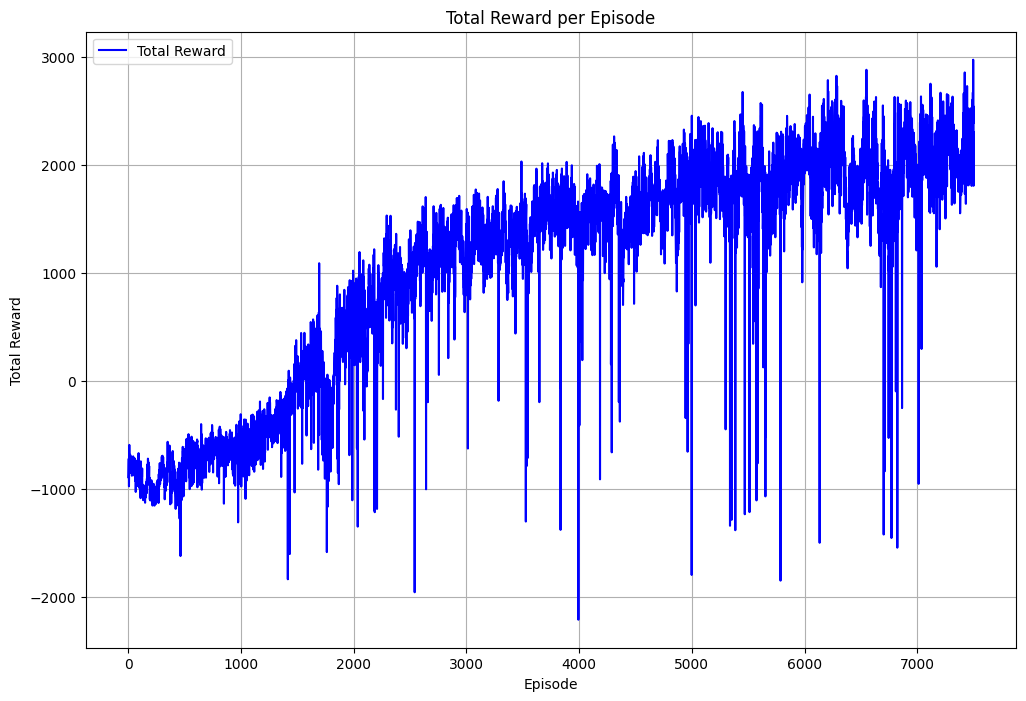

      episode  total_reward   value_loss   policy_loss
0           1   -894.414425  5430.958496  4.386902e-08
1           2   -862.174673  5116.721191  7.390976e-09
2           3   -771.571901  4333.743652  2.670288e-08
3           4   -767.055315  4222.027832 -1.621246e-08
4           5   -723.241908  3620.252686  1.239777e-08
...       ...           ...          ...           ...
7495     7496   2382.531366  3400.756348  8.583068e-09
7496     7497   2540.717846  5979.435547 -5.245209e-08
7497     7498   1804.141057  4680.467773  1.373291e-07
7498     7499   2194.611156  3283.687012  4.005432e-08
7499     7500   2302.039166  3848.408203 -1.535416e-07

[7500 rows x 4 columns]


In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the training log (a list of dictionaries) into a DataFrame
df_log = pd.DataFrame(training_log)

# Create a plot for Total Reward per Episode
plt.figure(figsize=(12, 8))
plt.plot(df_log['episode'], df_log['total_reward'], label='Total Reward', color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.legend()
plt.grid(True)
plt.show()
print(df_log)


In [ ]:
#As expected the reward is gradually improving as the model is learning  but there is lots of noise with sharp drops, the drops in the
#reward are when the cheetah tips over slightly and briefly stops forward progression which greatly hurts the rewards, 

The graph shows that total rewards start off negative but steadily improve, suggesting the agent is learning an effective running strategy in the HalfCheetah environment. 
PPO’s clipped objective helps keep updates stable while still allowing enough exploration as shown by how the graph wil quickly recover after steep drops, 
which explains the general upward trend despite occasional dips.

In [28]:
import os
import gymnasium as gym
import imageio
import numpy as np

def create_video_manual(agent, env_id, filename, video_length, fps):
    """
    Create a video by manually capturing frames from the environment and
    saving them as a video file.
    
    Args:
        agent: The trained agent (with a policy network).
        env_id (str): Environment ID (e.g., "HalfCheetah-v5").
        filename (str): Output filename for the video (including path).
        video_length (int): Total number of steps to record.
        fps (int): Frames per second for the output video.
    """
    video_dir = './vid'
    if not os.path.exists(video_dir):
        os.makedirs(video_dir)
    
    # Create the environment with render_mode set to 'rgb_array'
    env = gym.make(env_id, render_mode='rgb_array')
    # Optionally, force the metadata to use your desired FPS:
    env.metadata['video.frames_per_second'] = fps

    frames = []
    state, _ = env.reset()

    for _ in range(video_length):
        # Capture the frame
        frame = env.render()  # This returns an RGB image
        frames.append(frame)
        
        # Get action from your agent's policy network.
        # (Make sure your agent is built with the correct observation/action sizes for HalfCheetah)
        action, _ = agent.policy_net.get_action(state)
        state, reward, done, truncated, _ = env.step(action)
        
        # If the episode terminates early, reset the environment
        if done or truncated:
            state, _ = env.reset()

    env.close()
    
    # Save the frames to a video file using imageio
    video_path = os.path.join(video_dir, filename)
    imageio.mimsave(video_path, frames, fps=fps)
    print("Video saved as:", video_path)

# Example usage:
# (Make sure your agent was created using the appropriate observation and action dimensions for HalfCheetah-v5.)
create_video_manual(agent, env_id="HalfCheetah-v5", filename="half_cheetah_agent.mp4", video_length=500, fps=30)


Video saved as: ./vid/half_cheetah_agent.mp4


In [7]:
import imageio_ffmpeg
print(imageio_ffmpeg.get_ffmpeg_version())


7.1
